In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

# Snowball volcanoes

In [2]:
# How do aerosols/volcanic activity affect snowball earth
# Changed temperature gradients means less or more heat flux?
# Do I want to link the ocean circulation model from lab4?
    # decreased solar constant means you're closer to the GSP.
    # Slight pertubations (volcanoes) result in a snowball. (both CO2 and aerosol) on a short time scale 
    # ice cover affects albedo but also the ocean sink of CO2.  
    # Co2 builds up with more volcanoes
    # Tipping point of CO2 back to 


# Maybe some other usefu links
# https://science.sciencemag.org/content/299/5615/1997/tab-pdf
# https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/93JD03520
# https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/91GL02790

In [3]:
# peak optical depth 
tau_bar = 0.15
tau_mean = .00
def optical_flux(received, tau = tau_mean):
    transmitted = received/np.exp(tau)
    return transmitted

#half-life 
halflife_so2 = 30 # 21-28 days to h2so4 aersols, 33 is averaged for unoxidized pathways pathways also
# https://pubs.usgs.gov/pinatubo/self/
pinatubo_so2 = 20 # Megatons 
n = 12
# Parameterize different scenarios
timesteps = np.arange(0, 12)
halflives = timesteps*halflife_so2
decay = (1/(2**timesteps)) 
so2 = pinatubo_so2*decay # Mt
taus = tau_bar*decay # Optical depth
halflives, taus, optical_flux(1336, taus)

(array([  0,  30,  60,  90, 120, 150, 180, 210, 240, 270, 300, 330]),
 array([1.50000000e-01, 7.50000000e-02, 3.75000000e-02, 1.87500000e-02,
        9.37500000e-03, 4.68750000e-03, 2.34375000e-03, 1.17187500e-03,
        5.85937500e-04, 2.92968750e-04, 1.46484375e-04, 7.32421875e-05]),
 array([1149.9058565 , 1239.46529773, 1286.82774208, 1311.18338283,
        1323.5335279 , 1329.75215483, 1332.87241657, 1334.435292  ,
        1335.21741679, 1335.60865108, 1335.80431121, 1335.90215202]))

In [14]:
#Note that Budyko equation is written for temperature in celsius
#Note also that Budyko's original paper has radiation in units of kcal/cm2 each month ; we use W/m2
class budyko():
    """ energy balance climate model (Budyko style)"""
    
    def __init__(self, Q0=1336., alpha1=0.3,alpha2=0.6,s2=-0.482,T_s=-10., tau =0):
        """ constructor
        
        PARAMETERS:
        Q0: float
            incoming solar radiation (Solar constant) units are W/m2
        alpha_s: float
            albedo at ice line, taken to be average of alpha1 and alpha2     
        alpha1: float
            albedo in non-ice covered state
        alpha2: float
            albedo in ice-covered state
        s2: float
             coefficient for second order Legendre polynomial
        T_s: float
            critical temperature below which ice advances and shifts to alpha2 albedo
        tau: float
            optical depth due to 
        """
        self.Q0 = Q0
        # Tau
        self.tau = tau
        self.etau = np.exp(tau)

        # Albedo
        self.alpha_s = 0.5*(alpha1+alpha2)
        self.alpha1 = alpha1
        self.alpha2 = alpha2

        self.s2 = s2
        self.T_s = T_s
        return None   

    def get_roots(self):
        # Find roots: r1 is the coefficient for x^3; r2 for x^2; r1 for x, and r4 incorporates all constants
        r1 = -self.Q0*self.C*(self.alpha1-self.alpha2)*self.s2*(1/(8*self.B))
        r2 = ((3*self.Q0*self.s2)/8)*(1-self.alpha_s)
        r3 = ((self.Q0*self.C*(self.alpha1-self.alpha2))/(8*self.B))*(self.s2-2)
        r4 = (self.Q0/4)-((self.Q0*self.s2)/8)-((self.Q0*self.alpha_s)/4)+((self.Q0*self.alpha_s*self.s2)/8)+((self.Q0*self.C)/(4*self.B))-((self.Q0*self.C*self.alpha2)/(4*self.B))-self.k
        coeffs = [r1,r2,r3,r4]
        self.iceline = np.roots(coeffs)
        print(self.iceline)
        #math.asin() returns in radians
        soln1=math.asin(self.iceline[1])
        soln2=math.asin(self.iceline[2])
        print('Soln 1 =',math.degrees(soln1))
        print('Soln 2 =',math.degrees(soln2))
        self.icedeg = [math.degrees(soln1),math.degrees(soln2)]
        return(self.iceline,self.icedeg)

    def get_qofx(self, A=211.1, B=1.55, C=3.74, plotname = None):
        """ calculate the constant needed to solve for xs (sin ice line latitude) as a function of Q
          PARAMETERS:
        
         A: float
            Value taken from Lindzen & Farrell (1977); see Baker & Roe 2010  W/m2
          B: float
            Value taken from Lindzen & Farrell (1977); see Baker & Roe 2010  W/m2/C
            A+BT is the linear relationship between OLR and T; B reflects climate sensitivity
          C: float
            Value also taken from Lindzen & Farrell (1977). This term governs meridional redistribution of heat
            Units are W/m2/C; C(T(x)-Tavg); redistribution depends on difference of local T to global mean       
        """

        self.A = A
        self.B = B
        self.C = C
        
        #constant (see Roe & Baker 2010 Equation )
        self.k=self.A+(self.B*self.T_s)+(self.C*self.T_s)+((self.C*self.A)/self.B)

        #Solve EBCM for Q as a function of x (sin(ice-line lattiude)
        #define array for x     
        x=np.linspace(0.,1.,num=1000)
        self.x = x # sin latitude
        self.Q=(self.k/self.etau)/(((-self.C*(self.alpha1-self.alpha2)*self.s2*x**3)/(8*self.B))+(((3*self.s2/8)*(1-self.alpha_s)*x**2)+(((self.C*(self.alpha1-self.alpha2))/(8*self.B))*(self.s2-2)*x)+(1/4)-(self.s2/8)-(self.alpha_s/4)+(self.alpha_s*self.s2)/8)+(self.C/(4*self.B))-((self.C*self.alpha2)/(4*self.B)))
        self.Qrat=self.Q/self.Q0
        if plotname:
            self.plot_timeserie(plotname)
            self.plot_timeserie_lat(plotname)
        return(self.x, self.Q, self.Qrat, self.Q0)

 #Find the global stability point (ice line latitude)
    def find_gsp(self):
        # identify where Q(x) is minimum, where x = sin ice latitude
        posminQ = self.Q.argmin()
        print('index of minimum Q =', posminQ)
        print('minQ =',np.round(Q[posminQ],decimals=1),', Q0=', Q0,', minQ/Q0=',np.round(Q[posminQ]/Q0,decimals=3))
        self.gsp=self.x[posminQ]
        self.gsp_deg=math.degrees(math.asin(self.gsp))
        print('sin lat of GSP=', self.gsp)
        print('lat of GSP=',self.gsp_deg)
        return(self.gsp,self.gsp_deg)

#make a plot
    def plot_timeserie(self, plotname):
        """ plotting function """
        plt.figure(figsize=[10,8])
        plt.plot(self.Qrat, self.x, color='black')
        plt.xlim([0.9,1.3])
        plt.ylim([0,1])
        plt.xlabel('Q/Q0',fontsize=16)
        plt.ylabel('sine of ice-line latitude', fontsize=16)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.title('Budyko EBCM Solution', fontsize=16)  
        plt.grid(which = 'major')
        plt.savefig('img/{}.png'.format(plotname))
        return None 

#alternate plot as function of latitude rather than sin(latitude)
    def plot_timeserie_lat(self, plotname):
        plt.figure(figsize=[10,8])
        plt.plot(self.Qrat, np.rad2deg(np.arcsin(self.x)), color='black')
        plt.xlim([0.9,1.3])
        plt.ylim([0,90])
        plt.xlabel('Q/Q0',fontsize=16)
        plt.ylabel('ice-line latitude', fontsize=16)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.title('Budyko EBCM Solution', fontsize=16)
        plt.grid(which = 'major')
        plt.savefig('img/{}lat.png'.format(plotname))
        return None
    
#Fill in here for calculation of global temperature for iceline at any x "input_x"  and Qratio "input_Qrat"  
    def get_globalT(self,input_x,input_Qrat):
        # solve for global T based on solution for x
        ## STUDENTS TO FILL THIS IN
        a2 = self.alpha2
        a1 = self.alpha1
        s2 = self.s2
        p3 = .5* (5*input_x**3 - 3*input_x)
        p1 = input_x
        alpha_p = a2 + (a1-a2)*(input_x + s2/5* (p3 - p1))
        globalT = (input_Qrat* self.Q0/4*(1-alpha_p) - self.A)/self.B
        ## STUDENTS TO FILL THIS IN
        return(globalT)
    
    def plot_T(self, plotname = None):
        self.globalT = ebcm.get_globalT(input_x=self.x,input_Qrat=self.Qrat)
        """ plotting T vs sin lat """
        plt.figure(figsize=[10,8])
        plt.plot(self.globalT, self.x, color='black')
        plt.xlabel('global mean T (C)',fontsize=16)
        plt.ylabel('sine of ice-line latitude', fontsize=16)
        plt.ylim([0,1])
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.title('Budyko EBCM Solution, Global Temperature, with variation in Qratio', fontsize=16) 
        plt.grid(which = 'major')
        if plotname:
            plt.savefig('img/{}a.png'.format(plotname))        
        """ plotting T vs Q/Q0 """
        plt.figure(figsize=[10,8])
        plt.plot( self.Qrat, self.globalT, color='black')
        plt.ylabel('global mean T (C)',fontsize=16)
        plt.xlabel('Q/Q0',fontsize=16)
        plt.xlim([0.9,1.3])
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.title('Budyko EBCM Solution, Global Temperature, with variation in Qratio', fontsize=16) 
        plt.grid(which = 'major')
        if plotname:
            plt.savefig('img/{}b.png'.format(plotname))
        return None


1.1051709180756477
[-3.78173416  0.93070733  0.57161507]
Soln 1 = 68.54534407959036
Soln 2 = 34.86292640658076
index of minimum Q = 754
minQ = 1193.6 , Q0= 1336.0 , minQ/Q0= 0.893
sin lat of GSP= 0.7547547547547547
lat of GSP= 49.00394539581304


0.9156064879475411

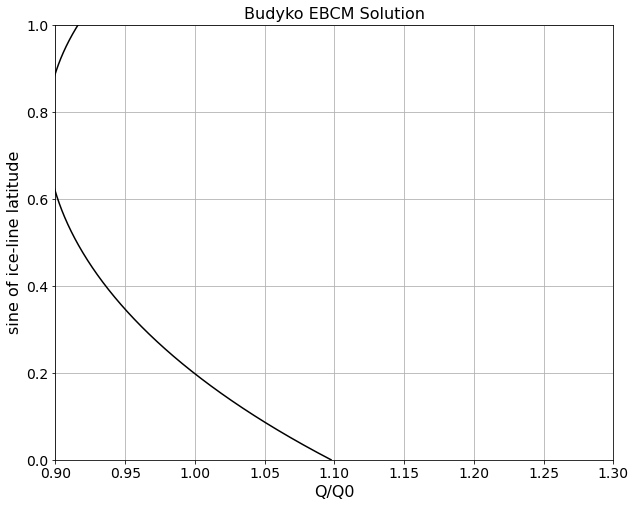

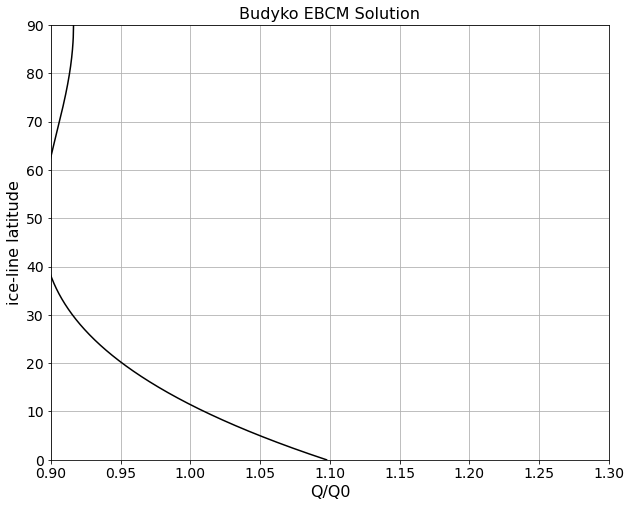

In [16]:
# Question 2
ebcm=budyko(tau = 0.1)
print(ebcm.etau)
x,Q,Qrat,Q0=ebcm.get_qofx(plotname = 'q2')
# Question 3
# Call get_roots to get eq sols (in sin x and degrees) for Q = 1
iceline,j =ebcm.get_roots()
# Find minimum Q, GSP
x_gsp,x_gsp_deg=ebcm.find_gsp()
# Question 4 (after increasing linspace spacing)
Qrat[np.degrees(np.arcsin(x)).searchsorted(85)]

In [6]:
# Do all the runs
# Optical depth 
try:
    del SaveRun
except:
    pass
B=1.55
C = 3.74
# params = {'tau' : taus} #want to use kwargs
for tau in taus:
    # Run with a different parameter choice
    ebcm = budyko(tau = tau)
    x,Q,Qrat,Q0=ebcm.get_qofx()
    try:
        # First time through; set up matrix to save result
        SaveRun = np.vstack([SaveRun,Qrat])
    except:
        # Save result
        SaveRun = Qrat.copy()
# Append one default run to the end
ebcm = budyko()
x,Q,Qrat,Q0=ebcm.get_qofx()
SaveRun = np.vstack([SaveRun,Qrat])

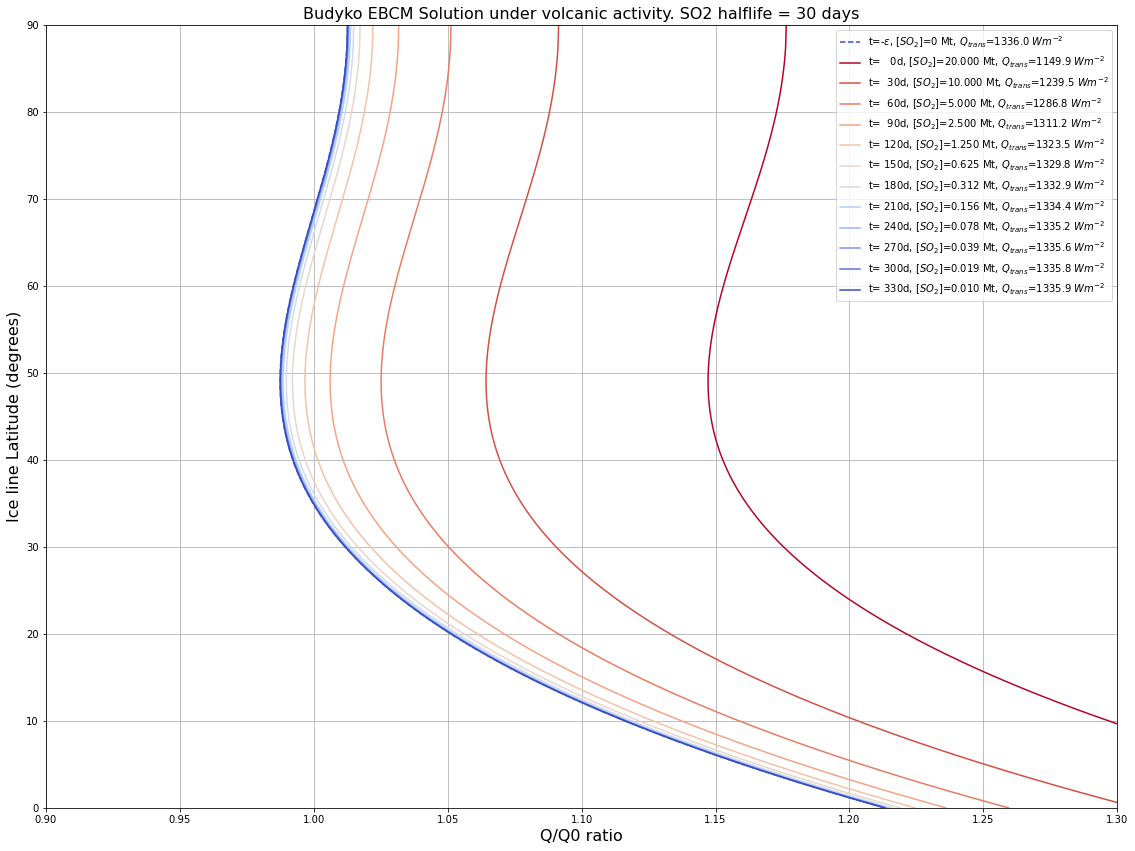

In [7]:
# Plot this stuff
plt.figure(figsize=np.array([4,3])*4.8)
# n = 12 #< len(timesteps)
plt.xlim([0.9,1.3])
plt.ylim([0,90])
plt.xlabel('Q/Q0 ratio',fontsize=16)
plt.ylabel('Ice line Latitude (degrees)', fontsize=16)
# plt.legend(handles=[lab1, lab2])
plt.title('Budyko EBCM Solution under volcanic activity. SO2 halflife = {} days'.format(halflife_so2), fontsize=16)
plt.grid(which = 'major')
lab = []

colormap = plt.cm.coolwarm_r

# Add original budyko plot
t = '-$\epsilon$'
info = (t, 0, Q0)
lines, = plt.plot(SaveRun[-1,:], np.rad2deg(np.arcsin(x)), ls = '--', color = colormap(.99), label = 't={:>4}, [$SO_2$]={} Mt, $Q_{{trans}}$={} $Wm^{{-2}}$'.format(*info))
lab.append(lines)
plt.legend(handles=lab,loc = 'upper right')
plt.savefig("img/t{}.png".format('-e'))

color_idx = np.linspace(0, 1, len(timesteps))
for t in timesteps:
    qbar = optical_flux(1336, taus[t])
    info = (halflives[t], round(so2[t],4), round(optical_flux(1336, taus[t]),1))
    lines, = plt.plot(SaveRun[t,:], np.rad2deg(np.arcsin(x)), color=colormap(color_idx[t]), label = 't={:4d}d, [$SO_2$]={:4.3f} Mt, $Q_{{trans}}$={} $Wm^{{-2}}$'.format(*info))
    lab.append(lines)
    plt.legend(handles=lab, loc = 'upper right')
    plt.savefig("img/t{}.png".format(t))

In [8]:
"Compare runs, Plotting against Latitude"
plt.figure(figsize=[10,8])
lab1, = plt.plot(SaveRun[0,:],np.rad2deg(np.arcsin(x)),'red', label = 'B={}; C=3.74,del={}'.format(Bs[0],round(C/Bs[0],2)))
lab2, = plt.plot(SaveRun[1,:],np.rad2deg(np.arcsin(x)),'blue',label = 'B={}; C=3.74 ,del={}'.format(Bs[1],round(C/Bs[1],2)))
" Add more comparisons here "
lab3, = plt.plot(SaveRun[2,:],np.rad2deg(np.arcsin(x)),'green',label = 'B={}; C=3.74,del={}'.format(Bs[2],round(C/Bs[2],2)))
lab4, = plt.plot(SaveRun[3,:],np.rad2deg(np.arcsin(x)),'black',label = 'B={}; C=3.74,del={}'.format(Bs[3],round(C/Bs[3],2)))
plt.xlim([0.9,1.3])
plt.ylim([0,90])
plt.xlabel('Q/Q0',fontsize=16)
plt.ylabel('Ice line Latitude', fontsize=16)
# plt.legend(handles=[lab1, lab2])
plt.legend(handles=[lab1, lab2, lab3, lab4])
plt.title('Budyko EBCM Solution, Comparison ', fontsize=16) 
plt.grid(which = 'major')
plt.savefig("img/q5a.png")

NameError: name 'Bs' is not defined

<Figure size 720x576 with 0 Axes>

In [ ]:
# 5b
# del SaveRun
# First time through; set up matrix to save result
B=1.55
Bs = np.array([.5, 1, 1.5, 2])* B
C = 3.74
for  in Bs:
    # Run with a different parameter choice
    x,Q,Qrat,Q0=ebcm.get_qofx(B=b)
    # Save result
    try:
        SaveRun = np.vstack([SaveRun,Q])
    except:
        SaveRun = Q.copy()
"Compare runs, Plotting against Latitude"
plt.figure(figsize=[10,8])
lab1, = plt.plot(SaveRun[0,:]/Q0,np.rad2deg(np.arcsin(x)),'red', label = 'B={}; C=3.74,del={}'.format(Bs[0],round(C/Bs[0],2)))
lab2, = plt.plot(SaveRun[1,:]/Q0,np.rad2deg(np.arcsin(x)),'blue',label = 'B={}; C=3.74 ,del={}'.format(Bs[1],round(C/Bs[1],2)))
" Add more comparisons here "
lab3, = plt.plot(SaveRun[2,:]/Q0,np.rad2deg(np.arcsin(x)),'green',label = 'B={}; C=3.74,del={}'.format(Bs[2],round(C/Bs[2],2)))
lab4, = plt.plot(SaveRun[3,:]/Q0,np.rad2deg(np.arcsin(x)),'black',label = 'B={}; C=3.74,del={}'.format(Bs[3],round(C/Bs[3],2)))
plt.xlim([0.9,1.3])
plt.ylim([0,90])
plt.xlabel('Q/Q0',fontsize=16)
plt.ylabel('Ice line Latitude', fontsize=16)
# plt.legend(handles=[lab1, lab2])
plt.legend(handles=[lab1, lab2, lab3, lab4])
plt.title('Budyko EBCM Solution, Comparison ', fontsize=16) 
plt.grid(which = 'major')
plt.savefig("img/q5a.png")

In [ ]:
# 5c
del SaveRun
# First time through; set up matrix to save result
B=1.55
C = 3.74
Cs = np.array([.5, 1, 1.5, 2])* C
for c in Cs:
    # Run with a different parameter choice
    x,Q,Qrat,Q0=ebcm.get_qofx(C = c)
    # Save result
    try:
        SaveRun = np.vstack([SaveRun,Q])
    except:
        SaveRun = Q.copy()
"Compare runs, Plotting against Latitude"
plt.figure(figsize=[10,8])
lab1, = plt.plot(SaveRun[0,:]/Q0,np.rad2deg(np.arcsin(x)),'red', label = 'B={}; C={},del={}'.format(B,Cs[0],round(Cs[0]/B,2)))
lab2, = plt.plot(SaveRun[1,:]/Q0,np.rad2deg(np.arcsin(x)),'blue',label = 'B={}; C={},del={}'.format(B,Cs[1],round(Cs[1]/B,2)))
" Add more comparisons here "
lab3, = plt.plot(SaveRun[2,:]/Q0,np.rad2deg(np.arcsin(x)),'green',label = 'B={}; C={},del={}'.format(B,Cs[2],round(Cs[2]/B,2)))
lab4, = plt.plot(SaveRun[3,:]/Q0,np.rad2deg(np.arcsin(x)),'black',label = 'B={}; C={},del={}'.format(B,Cs[3],round(Cs[3]/B,2)))
plt.xlim([0.9,1.3])
plt.ylim([0,90])
plt.xlabel('Q/Q0',fontsize=16)
plt.ylabel('Ice line Latitude', fontsize=16)
# plt.legend(handles=[lab1, lab2])
plt.legend(handles=[lab1, lab2, lab3, lab4])
plt.title('Budyko EBCM Solution, Comparison ', fontsize=16) 
plt.grid(which = 'major')
plt.savefig("img/q5c.png")

In [ ]:
# Rerun default, for consideration of Global Mean T
x,Q,Qrat,Q0=ebcm.get_qofx()
iceline,j =ebcm.get_roots()
x_gsp,x_gsp_deg=ebcm.find_gsp()

In [ ]:
x_gsp

In [ ]:
np.rad2deg(np.arcsin(iceline[1]))

In [ ]:
# 6c
# Need to fill in Qrat here
T_gsp = ebcm.get_globalT(input_x = x_gsp, input_Qrat = 0.987)
print(T_gsp, np.rad2deg(np.arcsin(x_gsp)))
Ticeline = ebcm.get_globalT(input_x = iceline[1],input_Qrat = 1)
print(Ticeline,np.rad2deg(np.arcsin(iceline[1])))

In [ ]:
# 6d
ebcm.plot_T("6d")